In [31]:
#import all the required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [3]:
#load all the required files
train_data = pd.read_csv("data/train.csv")
# print(train_data.head())
test_data = pd.read_csv("data/test.csv")
# print(test_data.head())

In [4]:
#Handling missing data
missing_values = train_data.isnull().sum()
missing_values_percent = train_data.isnull().sum()/len(train_data)

na_df = pd.concat([missing_values,train_data.dtypes,missing_values_percent],axis = 1,keys = ['Count','Type','Percent'])

na_df = na_df.sort_values(by= ['Count'],ascending = False)
na_df.head(10)



,Count,Type,Percent
PoolQC,1453,object,0.995205
MiscFeature,1406,object,0.963014
Alley,1369,object,0.937671
Fence,1179,object,0.807534
FireplaceQu,690,object,0.472603
LotFrontage,259,float64,0.177397
GarageYrBlt,81,float64,0.055479
GarageCond,81,object,0.055479
GarageType,81,object,0.055479
GarageFinish,81,object,0.055479


In [5]:
# 1. Dropping columns with almost half null values
train_data_step1 = train_data.drop(['PoolQC','MiscFeature','Alley','Fence','FireplaceQu'],axis =1)
print (len(train_data_step1))

1460


In [6]:
# 2. Dropping rows with Type object  and NA values
na_df_final = na_df[na_df['Percent']<0.2][na_df['Percent']>0]
na_df_final

na_col_list = na_df_final[na_df_final['Type'] == 'object'].index
train_data_step2 = train_data_step1
for col_name in na_col_list:
    train_data_step2 = train_data_step2.dropna(subset = [col_name], how = 'all')
print (len(train_data_step2))
train_data_step2.isna().sum().sort_values(ascending = False) 

1338


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


LotFrontage      244
SalePrice          0
Foundation         0
RoofMatl           0
Exterior1st        0
Exterior2nd        0
MasVnrType         0
MasVnrArea         0
ExterQual          0
ExterCond          0
BsmtQual           0
YearRemodAdd       0
BsmtCond           0
BsmtExposure       0
BsmtFinType1       0
BsmtFinSF1         0
BsmtFinType2       0
BsmtFinSF2         0
RoofStyle          0
YearBuilt          0
SaleCondition      0
OverallCond        0
MSSubClass         0
MSZoning           0
LotArea            0
Street             0
LotShape           0
LandContour        0
Utilities          0
LotConfig          0
                ... 
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
SaleType           0
GarageFinish       0
GarageType         0
HeatingQC          0
Fireplaces         0
CentralAir         0
Electrical         0
1stFlrSF     

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


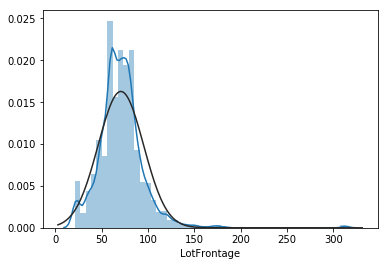

In [7]:
# 3. Handling numerical missing data
# 'LotFrontage' are the numerical columns to be handled
df_LF = train_data_step2[train_data_step2['LotFrontage'].notna() == True]
sns.distplot(df_LF['LotFrontage'],fit=norm)

In [8]:
# Filling LotFrontage nas
train_data_step3 = train_data_step2
LF_fillna_val = round(df_LF[df_LF['LotFrontage']<150]['LotFrontage'].mean())
train_data_step3['LotFrontage'] = train_data_step2['LotFrontage'].fillna(LF_fillna_val)
print(len(train_data_step2))

1338


In [9]:
# 4. Create dummy variables
train_data_step4 = pd.get_dummies(train_data_step3)
train_data_step4.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,0,0,1,0,0,0,0,1,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,0,0,0,1,0,0,0,0,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,0,0,1,0,0,0,0,1,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,0,0,1,1,0,0,0,0,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,0,0,0,1,0,0,0,0,1,0


In [10]:
# 5. Perform VIF
# Calculating VIF
def vif(df):
    
    df_vif = pd.DataFrame()
    df_vif["variables"] = df.columns
    df_vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

    return(df_vif)
train_data_step5 = train_data_step4.loc[:,~train_data_step4.columns.isin(['SalePrice','Id'])]
train_data_step5.head()
df_vif = vif(train_data_step5)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [11]:
df_vif.head()
df_vif.sort_values(by = 'VIF', ascending = True)
train_data_step5 = train_data_step5.drop(df_vif[df_vif['VIF'] > 36]['variables'],axis = 1)
train_data_step5.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFullBath,BsmtHalfBath,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,65.0,8450,7,5,2003,2003,196.0,1,0,...,548,0,61,0,0,0,0,0,2,2008
1,20,80.0,9600,6,8,1976,1976,0.0,0,1,...,460,298,0,0,0,0,0,0,5,2007
2,60,68.0,11250,7,5,2001,2002,162.0,1,0,...,608,0,42,0,0,0,0,0,9,2008
3,70,60.0,9550,7,5,1915,1970,0.0,1,0,...,642,0,35,272,0,0,0,0,2,2006
4,60,84.0,14260,8,5,2000,2000,350.0,1,0,...,836,192,84,0,0,0,0,0,12,2008


In [91]:
# 6. Removing one column at a time to get final set
train_data_step6 = train_data_step5.loc[:,~train_data_step5.columns.isin(['MSSubClass','GarageYrBlt','YearRemodAdd','YrSold','YearBuilt','TotRmsAbvGrd','OverallQual','GarageCars','KitchenAbvGr','BedroomAbvGr','LotFrontage','FullBath','OverallCond','GarageArea'])]
df_vif = vif(train_data_step6)
df_vif.sort_values(by = 'VIF',ascending = True)

,variables,VIF
12,MiscVal,1.012789
9,3SsnPorch,1.022854
11,PoolArea,1.034300
3,BsmtHalfBath,1.099727
8,EnclosedPorch,1.137315
10,ScreenPorch,1.152277
1,MasVnrArea,1.496270
7,OpenPorchSF,1.659456
4,HalfBath,1.742842
6,WoodDeckSF,1.792298


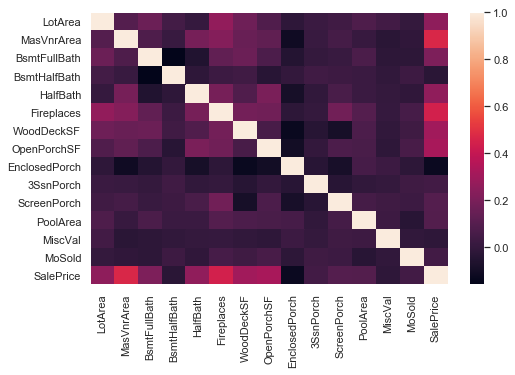

In [101]:
# 7. Final Training Data set
final_col_list = []
for col_name in df_vif['variables']:
    final_col_list.append(col_name)
final_col_list.append('SalePrice')
train_data_final = train_data_step4.loc[:,final_col_list]
train_data_final.head()
corr_mat = train_data_final.corr()
# print(corr_mat)
sns.set(rc = {'figure.figsize':(8,5)})
sns.heatmap(corr_mat)

In [95]:
# Model training
X = train_data_final.drop('SalePrice',axis = 1)
y = train_data_final['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 51)

LR = LinearRegression()
LR.fit(X_train,y_train)

y_pred = LR.predict(X_test)

df_pred = pd.DataFrame({'Actual': y_test, 'Predicted': np.round(y_pred.flatten())})
df_pred
# plt.bar(df_pred.index,df_pred['Actual'])
# plt.bar(df_pred.index,df_pred['Predicted'])
# df_pred = pd.concat([y_test,y_pred])
# df_pred.head()
r2_score(y_test,y_pred)

0.41307965752292264